In [1]:
using Images
using Statistics
using Plots
using DSP

In [2]:
function mask_site(file; n_sites=1)
    img = load(file)
    im_array = Float64.(img)
    frame_avg = mean(im_array, dims=(1,2))
    # Do frame averaging
    im_array = im_array ./ frame_avg
    # Do mean value subtraction
    im_array = im_array .- mean(im_array)
    # Use stack sum projection to find polarity patch(es)
    avgimg = mean(im_array, dims=(3))[:,:,1]
    max_bin = 0
    threshold = 0.55
    bin = avgimg .> maximum(avgimg)*threshold
    bin_lab = label_components(bin)
    masks = zeros(size(im_array)[1], size(im_array)[2], size(im_array)[3], n_sites)
    for i in range(1,n_sites)
        bin = bin .- max_bin             # Half max of average is used as threshold
        max_loc = findmax(bin.*avgimg)[2]              # Find single connected component from binary with highest value
        max_lab = bin_lab[max_loc]                  
        max_bin = bin_lab .== max_lab               # Make mask only around correct component
        im_masked = im_array .* max_bin
        masks[:,:,:,i] = im_masked
    end
    return masks
end

mask_site (generic function with 1 method)

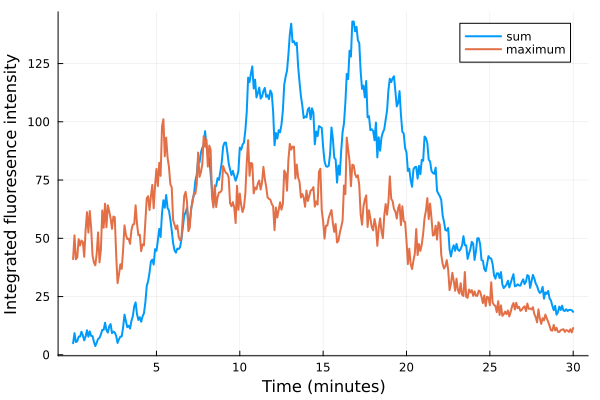

In [88]:
file = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/1patch/movie1-cell1.tif"
patch = mask_site(file)
t = range(0,60/5*30)*(5/60) # Convert from 1 frame every 5 sec, to minutes
plot(t, sum(patch, dims=(1,2))[1,1,:], xticks=range(1,6)*5, linewidth=2, label="sum", xlabel="Time (minutes)", ylabel="Integrated fluoresence intensity")
plot!(t, maximum(patch, dims=(1,2))[1,1,:]*10, xticks=range(1,6)*5, linewidth=2, label="maximum", xlabel="Time (minutes)", ylabel="Integrated fluoresence intensity")

In [77]:
function crop_time(signal, frames, thresh)
    start = Integer(findall(signal .> (maximum(signal) + minimum(signal))*thresh)[1])
    if start + frames < length(signal)
        crop_signal = signal[start:start+Integer(frames)]
        return crop_signal
    else 
        println("signal does not reach threshold early enough, using end-frames as start")
        crop_signal = signal[end-Integer(frames):end]
    end
end

crop_time (generic function with 1 method)

1.25

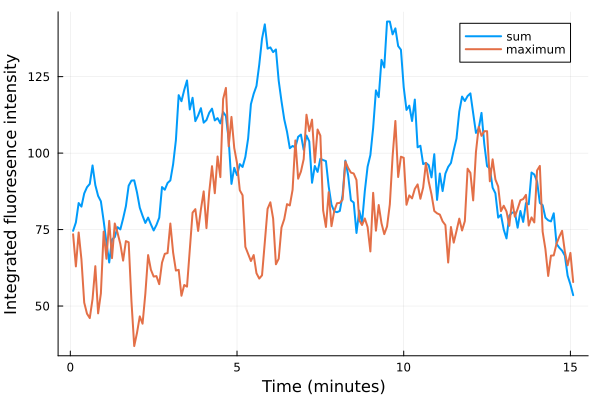

In [93]:
file = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/1patch/movie1-cell1.tif"
patch = mask_site(file)
max_patch = maximum(patch, dims=(1,2))[1,1,:]
crop_max = crop_time(max_patch, 15*(60/5), 0.5)
sum_patch = sum(patch, dims=(1,2))[1,1,:]
crop_sum = crop_time(sum_patch, 15*(60/5), 0.5)
t = range(1,length(crop_patch))*(5/60) # Convert from 1 frame every 5 sec, to minutes
plot(t, crop_sum, linewidth=2, label="sum", xlabel="Time (minutes)", ylabel="Integrated fluoresence intensity")
plot!(t, crop_max*12, linewidth=2, label="maximum", xlabel="Time (minutes)", ylabel="Integrated fluoresence intensity")

In [12]:
using DSP

In [129]:
pdg_max = DSP.Periodograms.periodogram((max_patch.-mean(max_patch))*12)
pdg_crop_max = DSP.Periodograms.periodogram((crop_max.-mean(crop_max))*12)
pdg_sum = DSP.Periodograms.periodogram(sum_patch.-mean(sum_patch))
pdg_crop_sum = DSP.Periodograms.periodogram(crop_sum.-mean(crop_sum))

DSP.Periodograms.Periodogram{Float64, AbstractFFTs.Frequencies{Float64}, Vector{Float64}}([3.492705803111416e-25, 20369.763395084283, 6658.207953104113, 6819.6367852406665, 342.7831145125186, 10724.316164427302, 2855.648794589731, 1769.9449426389886, 9280.44753862551, 53.53644650644852  …  86.2224153212507, 24.494416001061705, 8.123956348621897, 0.7892491280071883, 32.48928928035072, 10.995881150683559, 18.22181123278228, 55.28514874253636, 9.948325624066724, 46.24017887259741], [0.0, 0.005291005291005291, 0.010582010582010581, 0.015873015873015872, 0.021164021164021163, 0.026455026455026454, 0.031746031746031744, 0.037037037037037035, 0.042328042328042326, 0.047619047619047616  …  0.4497354497354497, 0.455026455026455, 0.4603174603174603, 0.4656084656084656, 0.4708994708994709, 0.47619047619047616, 0.48148148148148145, 0.48677248677248675, 0.49206349206349204, 0.4973544973544973])

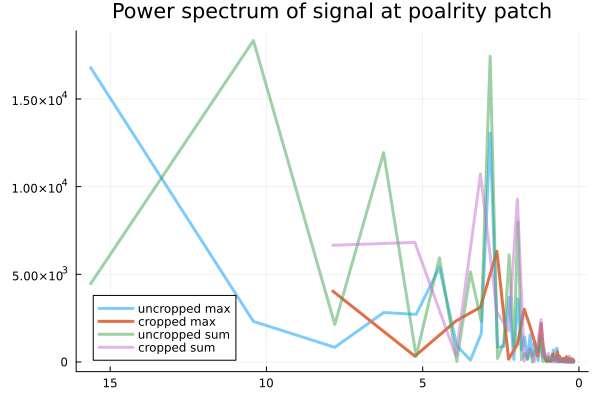

In [130]:
plot(1 ./ pdg_max.freq[3:end] .* (5/60), pdg_max.power[3:end], xflip = true, label="uncropped max", linewidth=3, alpha=0.5, title="Power spectrum of signal at poalrity patch")
plot!(1 ./ pdg_crop_max.freq[3:end] .* (5/60), pdg_crop_max.power[3:end], xflip = true, label="cropped max", linewidth=3, alpha=1, title="Power spectrum of signal at poalrity patch")
plot!(1 ./ pdg_sum.freq[3:end] .* (5/60), pdg_sum.power[3:end], xflip = true, label="uncropped sum", linewidth=3, alpha=0.5, title="Power spectrum of signal at poalrity patch")
plot!(1 ./ pdg_crop_sum.freq[3:end] .* (5/60), pdg_crop_sum.power[3:end], xflip = true, label="cropped sum", linewidth=3, alpha=0.5, title="Power spectrum of signal at poalrity patch",legend=:bottomleft)


In [125]:
pdg_max = DSP.Periodograms.periodogram((max_patch)*12)
pdg_crop_max = DSP.Periodograms.periodogram((crop_max)*12)
pdg_sum = DSP.Periodograms.periodogram(sum_patch)
pdg_crop_sum = DSP.Periodograms.periodogram(crop_sum)

DSP.Periodograms.Periodogram{Float64, AbstractFFTs.Frequencies{Float64}, Vector{Float64}}([1.7173611830164213e6, 50310.65074270256, 26085.90932492229, 449.6880086546593, 9011.28879599327, 5264.746232428667, 13561.858025855317, 12717.929605161926, 4694.132170566272, 4078.5280160173993  …  89.07151054051447, 31.10444117475489, 63.94515743630243, 48.45345713288306, 6.9732705542592255, 43.55947952170035, 3.686391085610341, 23.840859569962564, 25.914298768334405, 42.20109032852331], [0.0, 0.005291005291005291, 0.010582010582010581, 0.015873015873015872, 0.021164021164021163, 0.026455026455026454, 0.031746031746031744, 0.037037037037037035, 0.042328042328042326, 0.047619047619047616  …  0.4497354497354497, 0.455026455026455, 0.4603174603174603, 0.4656084656084656, 0.4708994708994709, 0.47619047619047616, 0.48148148148148145, 0.48677248677248675, 0.49206349206349204, 0.4973544973544973])

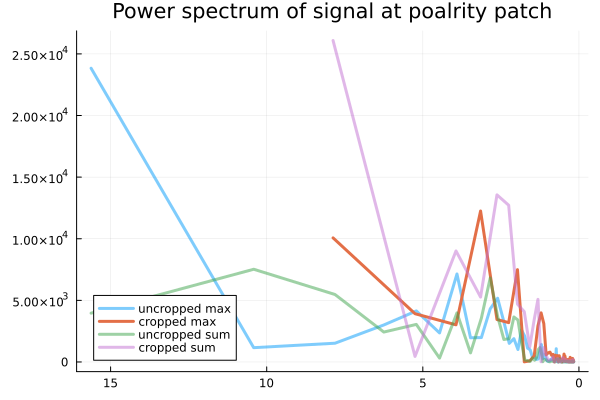

In [128]:
plot(1 ./ pdg_max.freq[3:end] .* (5/60), pdg_max.power[3:end], xflip = true, label="uncropped max", linewidth=3, alpha=0.5, title="Power spectrum of signal at poalrity patch")
plot!(1 ./ pdg_crop_max.freq[3:end] .* (5/60), pdg_crop_max.power[3:end], xflip = true, label="cropped max", linewidth=3, alpha=1, title="Power spectrum of signal at poalrity patch")
plot!(1 ./ pdg_sum.freq[3:end] .* (5/60), pdg_sum.power[3:end], xflip = true, label="uncropped sum", linewidth=3, alpha=0.5, title="Power spectrum of signal at poalrity patch")
plot!(1 ./ pdg_crop_sum.freq[3:end] .* (5/60), pdg_crop_sum.power[3:end], xflip = true, label="cropped sum", linewidth=3, alpha=0.5, title="Power spectrum of signal at poalrity patch",legend=:bottomleft)


signal does not reach threshold early enough, using end-frames as start
signal does not reach threshold early enough, using end-frames as start
signal does not reach threshold early enough, using end-frames as start
signal does not reach threshold early enough, using end-frames as start
signal does not reach threshold early enough, using end-frames as start
signal does not reach threshold early enough, using end-frames as start
signal does not reach threshold early enough, using end-frames as start
signal does not reach threshold early enough, using end-frames as start
signal does not reach threshold early enough, using end-frames as start
signal does not reach threshold early enough, using end-frames as start
signal does not reach threshold early enough, using end-frames as start
signal does not reach threshold early enough, using end-frames as start
signal does not reach threshold early enough, using end-frames as start
signal does not reach threshold early enough, using end-frames a

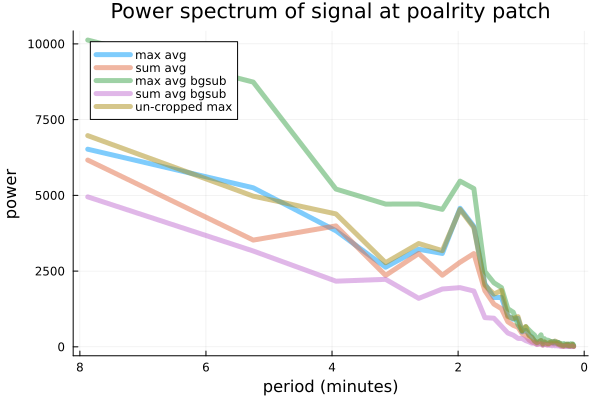

In [164]:
dir = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/1patch/"
wt_files = readdir(dir)
plot(label="WT", ylabel="power", xlabel="period (minutes)", title="3XGFP-Bem1 signal in polarity patch")
t = range(0,60/5*30)*(5/60) # Convert from 1 frame every 5 sec, to minutes
max_powers = zeros(95)
sum_powers = zeros(95)
max_powers2 = zeros(95)
sum_powers2 = zeros(95)
ucm_powers = zeros(95)
n=0
frequencies = 0
for f in wt_files
    mask = mask_site("$dir$f")
    max_patch = maximum(mask, dims=(1,2))[1,1,:]
    sum_patch = sum(mask, dims=(1,2))[1,1,:]
    crop_max = crop_time(max_patch, 15*(60/5), 0.5)
    crop_sum = crop_time(sum_patch, 15*(60/5), 0.5)
    pdg_sum = DSP.Periodograms.periodogram(crop_sum)
    pdg_max = DSP.Periodograms.periodogram(crop_max)
    max_powers = max_powers .+ pdg_max.power
    sum_powers = sum_powers .+ pdg_sum.power
    pdg_sum2 = DSP.Periodograms.periodogram(crop_sum.-mean(crop_sum))
    pdg_max2 = DSP.Periodograms.periodogram(crop_max.-mean(crop_max))
    max_powers2 = max_powers2 .+ pdg_max2.power
    sum_powers2 = sum_powers2 .+ pdg_sum2.power
    img = load("$dir$f")
    im_array = Float64.(img)
    frame_avg = mean(im_array, dims=(1,2))
    im_array = im_array ./ frame_avg
    im_array = im_array .- mean(im_array)
    ucm = maximum(im_array, dims=(1,2))[1,1,:]
    crop_ucm = crop_time(ucm, 15*(60/5), 0.5)
    pdg_ucm = DSP.Periodograms.periodogram(crop_ucm)
    ucm_powers = ucm_powers .+ pdg_ucm.power
    frequencies = pdg_sum.freq
    n+=1
end
plot!(1 ./ frequencies[3:end] .* (5/60), max_powers[3:end]*2, xflip = true, label="max avg", linewidth=5, alpha=0.5, title="Power spectrum of signal at poalrity patch")
plot!(1 ./ frequencies[3:end] .* (5/60), sum_powers[3:end]/n, xflip = true, label="sum avg", linewidth=5, alpha = 0.5)
plot!(1 ./ frequencies[3:end] .* (5/60), max_powers2[3:end]*4, xflip = true, label="max avg bgsub", linewidth=5, alpha = 0.5)
plot!(1 ./ frequencies[3:end] .* (5/60), sum_powers2[3:end]/n, xflip = true, label="sum avg bgsub", linewidth=5, alpha = 0.5)
plot!(1 ./ frequencies[3:end] .* (5/60), ucm_powers[3:end]*2, xflip = true, label="un-cropped max", linewidth=5, alpha = 0.5)
#savefig("wt_periods.png")

In [156]:
dir = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/1patch/"
wt_files = readdir(dir)
plot(label="WT", ylabel="power", xlabel="period (minutes)", title="3XGFP-Bem1 signal in polarity patch")
t = range(0,60/5*30)*(5/60) # Convert from 1 frame every 5 sec, to minutes
max_powers = zeros(95)
sum_powers = zeros(95)
max_powers2 = zeros(95)
sum_powers2 = zeros(95)
n=0
frequencies = 0
for f in wt_files
    mask = mask_site("$dir$f")
    crop_max = crop_time(mask, 15*(60/5), 0.5)
    pdg_max2 = DSP.Periodograms.periodogram(crop_max.-mean(crop_max))
    plot!(1 ./ pdg_max2.freq[3:end] .* (5/60), pdg_max2.power[3:end], xflip = true, label=false, linewidth=1, title="Power spectrum of signal at poalrity patch", alpha=0.5)
    max_powers2 = max_powers2 .+ pdg_max2.power
    frequencies = pdg_max2.freq
    n+=1
end
#plot!(1 ./ frequencies[3:end] .* (5/60), max_powers[3:end]*2, xflip = true, label="max avg", linewidth=5, alpha=0.5, title="Power spectrum of signal at poalrity patch")
#plot!(1 ./ frequencies[3:end] .* (5/60), sum_powers[3:end]/n, xflip = true, label="sum avg", linewidth=5, alpha = 0.5)
plot!(1 ./ frequencies[3:end] .* (5/60), max_powers2[3:end]/n, xflip = true, label="max avg bgsub", linewidth=5, alpha = 0.5, color="grey")
#savefig("wt_periods.png")

MethodError: MethodError: no method matching Integer(::CartesianIndex{4})

Closest candidates are:
  (::Type{T})(!Matched::BigFloat) where T<:Integer
   @ Base mpfr.jl:378
  (::Type{Ti})(!Matched::FixedPoint) where Ti<:Integer
   @ FixedPointNumbers ~/.julia/packages/FixedPointNumbers/Dn4hv/src/FixedPointNumbers.jl:72
  (::Type{<:Integer})(!Matched::Sockets.IPAddr)
   @ Sockets ~/.julia/juliaup/julia-1.10.2+0.x64.linux.gnu/share/julia/stdlib/v1.10/Sockets/src/IPAddr.jl:11
  ...


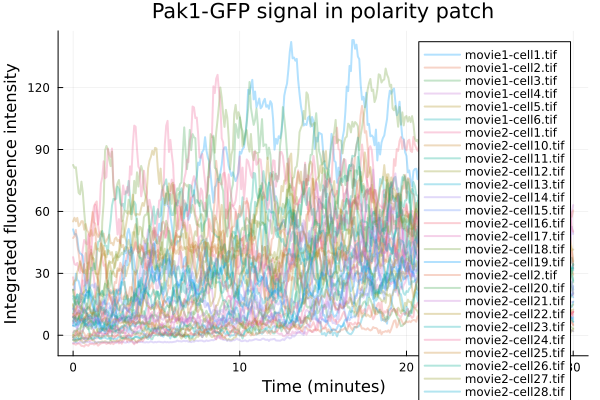

In [18]:
dir = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/1patch/"
wt_files = readdir(dir)
plot(label="WT", xlabel="Time (minutes)", ylabel="Integrated fluoresence intensity")
for f in wt_files
    mask = mask_site("$(dir)$(f)")
    sig_patch = sum(patch, dims=(1,2))[1,1,:]
    crop_patch = crop_time(sig_patch, 15*(60/5), 0.5)
    plot!(t, mask_sum, linewidth=2, label=f, title="Pak1-GFP signal in polarity patch", alpha=0.3)
end
plot!()

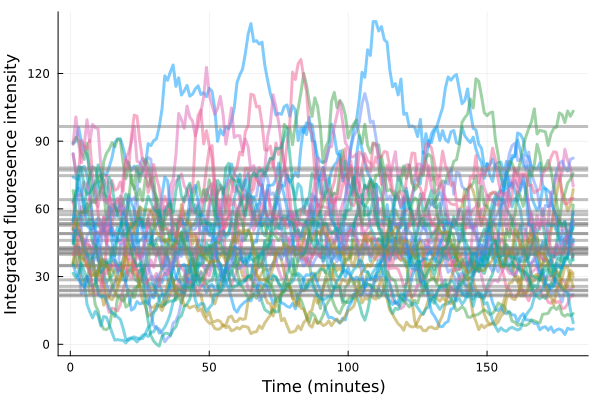

In [25]:
dir = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/1patch/"
wt_files = readdir(dir)
plot(label="WT", xlabel="Time (minutes)", ylabel="Integrated fluoresence intensity")
t = range(0,60/5*30)*(5/60) # Convert from 1 frame every 5 sec, to minutes
for f in wt_files
    mask = mask_site("$(dir)$(f)")
    mask_sum = sum(mask, dims=(1,2))[1,1,:]
    #plot!(t, mask_sum, linewidth=1, label=f)
    thresh = 0.6
    start = Integer(findall(mask_sum .> (maximum(mask_sum) + minimum(mask_sum))*thresh)[1])
    if start + 15*(60/5) < 361
        #window_t = range(start*5/60, start*5/60 + 15, step=5/60)
        plot!(mask_sum[start:start+Integer(60/5*15)], linewidth=3, alpha=0.5, label=false)
        hline!([mean(mask_sum[start:start+Integer(60/5*15)])], linewidth=3, alpha=0.5, color="grey", label=false)
    end
end
plot!()
#savefig("wt_signals.png")

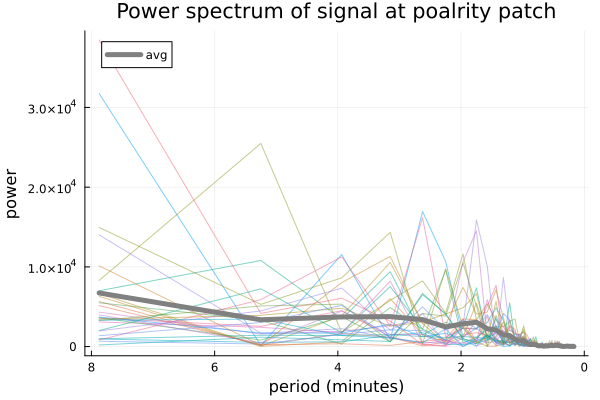

In [30]:
dir = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/1patch/"
wt_files = readdir(dir)
plot(label="WT", ylabel="power", xlabel="period (minutes)", title="3XGFP-Bem1 signal in polarity patch")
t = range(0,60/5*30)*(5/60) # Convert from 1 frame every 5 sec, to minutes
powers = zeros(95)
n=0
frequencies = 0
for f in wt_files
    mask = mask_site("$dir$f")
    mask_sum = sum(mask, dims=(1,2))[1,1,:]
    thresh = 0.6
    start = Integer(findall(mask_sum .> (maximum(mask_sum) + minimum(mask_sum))*thresh)[1])
    if start + 15*(60/5) < 361
        window_t = range(start*5/60, start*5/60 + 15, step=5/60)
        crop_sum = mask_sum[start:start+Integer(60/5*15)]
        pdg = DSP.Periodograms.periodogram(crop_sum)
        plot!(1 ./ pdg.freq[3:end] .* (5/60), pdg.power[3:end], xflip = true, label=false, linewidth=1, title="Power spectrum of signal at poalrity patch", alpha=0.5)
        powers = powers .+ pdg.power
        frequencies = pdg.freq
        n+=1
    end
end
plot!(1 ./ frequencies[3:end] .* (5/60), powers[3:end]/n, xflip = true, label="avg", linewidth=5, title="Power spectrum of signal at poalrity patch", color="grey")
#savefig("wt_periods.png")

In [58]:
del_files = readdir("../movies/2024_08_07-3XBG-pak1del/del-1patch/")
plot(label="del", xlabel="Time (minutes)", ylabel="Integrated fluoresence intensity", title="3XGFP-Bem1 signal in polarity patch")
t = range(0,60/5*30)*(5/60) # Convert from 1 frame every 5 sec, to minutes
for f in del_files
    mask = mask_site("../movies/2024_08_07-3XBG-pak1del/del-1patch/$f")
    mask_sum = sum(mask, dims=(1,2))[1,1,:]
    plot!(t, mask_sum, linewidth=1, label=f)
    thresh = 0.3
    start = Integer(findall(mask_sum .> (maximum(mask_sum) + minimum(mask_sum))*thresh)[1])
    window_t = range(start*5/60, start*5/60 + 15, step=5/60)
    plot!(window_t, mask_sum[start:start+Integer(60/5*15)], linewidth=5, label=false, color="grey", alpha = 0.6)
end
plot!()
#savefig("del_signals.png")

"/home/dinosaur/Lab/Polarity/proj/PatchDynamics/notebooks/del_signals.png"

In [57]:
powers = zeros(95)
n=0
del_files = readdir("../movies/2024_08_07-3XBG-pak1del/del-1patch/")
plot(label="del", xlabel="Time (minutes)", ylabel="Integrated fluoresence intensity", title="3XGFP-Bem1 signal in polarity patch")
t = range(0,60/5*30)*(5/60) # Convert from 1 frame every 5 sec, to minutes
for f in del_files
    mask = mask_site("../movies/2024_08_07-3XBG-pak1del/del-1patch/$f")
    mask_sum = sum(mask, dims=(1,2))[1,1,:]
    thresh = 0.3
    start = Integer(findall(mask_sum .> (maximum(mask_sum) + minimum(mask_sum))*thresh)[1])
    crop_sum = mask_sum[start:start+Integer(60/5*15)]
    pdg = DSP.Periodograms.periodogram(crop_sum)
    plot!(1 ./ pdg.freq[3:end] .* (5/60), pdg.power[3:end], xflip = true, label=f, linewidth=1, title="Power spectrum of signal at poalrity patch", alpha=0.5)
    powers = powers .+ pdg.power
    n+=1 
end
plot!(1 ./ frequencies[3:end] .* (5/60), powers[3:end]/n, xflip = true, label="avg", linewidth=5, title="Power spectrum of signal at poalrity patch", color="grey")
#savefig("del_periods.png")

"/home/dinosaur/Lab/Polarity/proj/PatchDynamics/notebooks/del_periods.png"

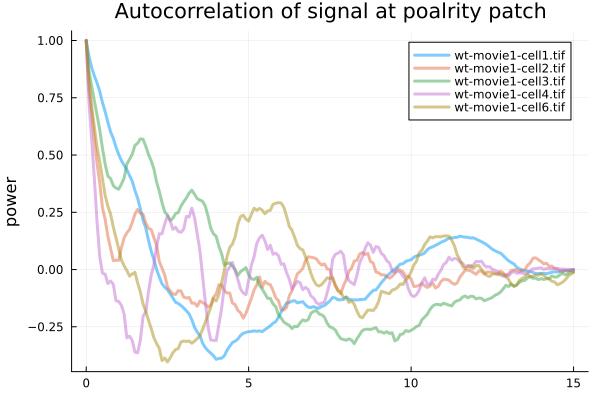

In [48]:
wt_files = readdir("../movies/2024_08_07-3XBG-pak1del/wt-1patch/")
plot(label="WT", ylabel="power", title="3XGFP-Bem1 signal in polarity patch")
t = range(0,60/5*15)*(5/60) # Convert from 1 frame every 5 sec, to minutes
n=0
for f in wt_files
    mask = mask_site("../movies/2024_08_07-3XBG-pak1del/wt-1patch/$f")
    mask_sum = sum(mask, dims=(1,2))[1,1,:]
    thresh = 0.6
    start = Integer(findall(mask_sum .> (maximum(mask_sum) + minimum(mask_sum))*thresh)[1])
    window_t = range(start*5/60, start*5/60 + 15, step=5/60)
    crop_sum = mask_sum[start:start+Integer(60/5*15)]
    ac = autocor(crop_sum, range(0,length(crop_sum)-1))
    plot!(t, ac, label=f, linewidth=3, title="Autocorrelation of signal at poalrity patch", alpha=0.5)
    n+=1
end
plot!()
#savefig("wt_autocor.png")

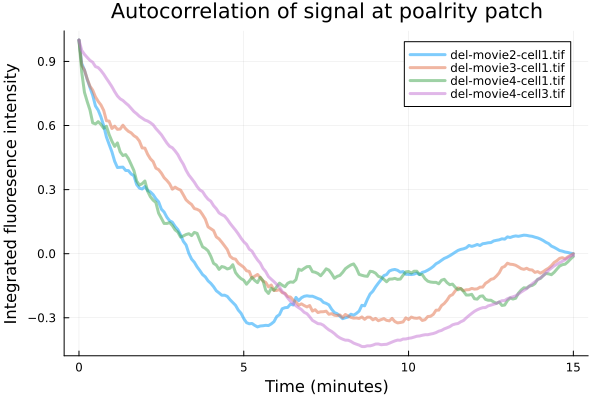

In [50]:
del_files = readdir("../movies/2024_08_07-3XBG-pak1del/del-1patch/")
plot(label="del", xlabel="Time (minutes)", ylabel="Integrated fluoresence intensity", title="3XGFP-Bem1 signal in polarity patch")
t = range(0,60/5*15)*(5/60) # Convert from 1 frame every 5 sec, to minutes
powers = zeros(95)
n=0
for f in del_files
    mask = mask_site("../movies/2024_08_07-3XBG-pak1del/del-1patch/$f")
    mask_sum = sum(mask, dims=(1,2))[1,1,:]
    thresh = 0.3
    start = Integer(findall(mask_sum .> (maximum(mask_sum) + minimum(mask_sum))*thresh)[1])
    window_t = range(start*5/60, start*5/60 + 15, step=5/60)
    crop_sum = mask_sum[start:start+Integer(60/5*15)]
    crop_sum = crop_sum .- mean(crop_sum)
    ac = autocor(crop_sum, range(0,length(crop_sum)-1))
    plot!(t, ac, label=f, linewidth=3, title="Autocorrelation of signal at poalrity patch", alpha=0.5)
    n+=1
end
plot!()
#savefig("del_autocor.png")

In [64]:
wt_files = readdir("../movies/2024_08_07-3XBG-pak1del/wt-1patch/")
plot(label="WT", ylabel="power", title="3XGFP-Bem1 signal in polarity patch")
t = range(0,60/5*15)*(5/60) # Convert from 1 frame every 5 sec, to minutes
n=0
powers = zeros(95)
for f in wt_files
    mask = mask_site("../movies/2024_08_07-3XBG-pak1del/wt-1patch/$f")
    mask_sum = sum(mask, dims=(1,2))[1,1,:]
    thresh = 0.6
    start = Integer(findall(mask_sum .> (maximum(mask_sum) + minimum(mask_sum))*thresh)[1])
    window_t = range(start*5/60, start*5/60 + 15, step=5/60)
    crop_sum = mask_sum[start:start+Integer(60/5*15)]
    ac = autocor(crop_sum, range(0,length(crop_sum)-1))
    pdg = DSP.Periodograms.periodogram(ac)
    plot!(1 ./ pdg.freq[2:end] .* (5/60), pdg.power[2:end], xflip = true, label=f, linewidth=1, title="Power spectrum of signal at poalrity patch", alpha=0.5)
    powers = powers .+ pdg.power
    n+=1 
end
plot!(1 ./ frequencies[2:end] .* (5/60), powers[2:end]/n, xflip = true, label="avg", linewidth=5, title="Power spectrum of signal at poalrity patch", color="grey")
#savefig("wt_autocor_periods.png")

"/home/dinosaur/Lab/Polarity/proj/PatchDynamics/notebooks/wt_autocor_periods.png"

In [63]:
del_files = readdir("../movies/2024_08_07-3XBG-pak1del/del-1patch/")
plot(label="del", xlabel="Time (minutes)", ylabel="Integrated fluoresence intensity", title="3XGFP-Bem1 signal in polarity patch")
t = range(0,60/5*15)*(5/60) # Convert from 1 frame every 5 sec, to minutes
powers = zeros(95)
n=0
for f in del_files
    mask = mask_site("../movies/2024_08_07-3XBG-pak1del/del-1patch/$f")
    mask_sum = sum(mask, dims=(1,2))[1,1,:]
    thresh = 0.3
    start = Integer(findall(mask_sum .> (maximum(mask_sum) + minimum(mask_sum))*thresh)[1])
    window_t = range(start*5/60, start*5/60 + 15, step=5/60)
    crop_sum = mask_sum[start:start+Integer(60/5*15)]
    crop_sum = crop_sum .- mean(crop_sum)
    ac = autocor(crop_sum, range(0,length(crop_sum)-1))
    pdg = DSP.Periodograms.periodogram(ac)
    plot!(1 ./ pdg.freq[2:end] .* (5/60), pdg.power[2:end], xflip = true, label=f, linewidth=1, title="Power spectrum of signal at poalrity patch", alpha=0.5)
    powers = powers .+ pdg.power
    n+=1 
end
plot!(1 ./ frequencies[2:end] .* (5/60), powers[2:end]/n, xflip = true, label="avg", linewidth=5, title="Power spectrum of signal at poalrity patch", color="grey")
#savefig("del_autocor_periods.png")

"/home/dinosaur/Lab/Polarity/proj/PatchDynamics/notebooks/del_autocor_periods.png"

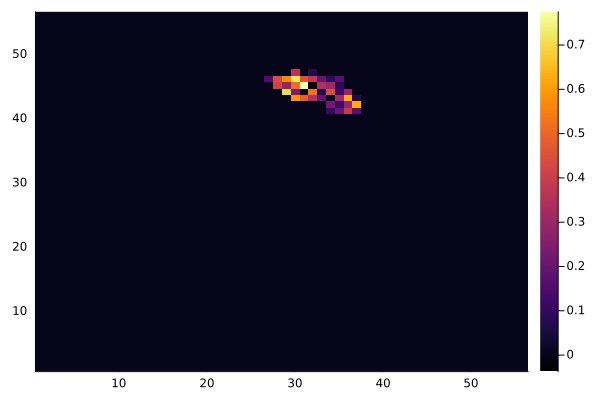

In [301]:
heatmap(mask[:,:,Integer(8*(60/5)),1])